In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

matplotlib.rcParams.update({'figure.figsize': (15, 9)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})
%config InlineBackend.figure_format = 'retina'

# Machine Learning lab 3: exploring image data
## Jake Rowland and Paul Herz
2017-09-21

## 1. Introduction

In order to fulfill the requirements of this lab as well as future labs (presumably involving a prediction task), we sought a dataset with clear and unambiguous classes (pre-labelled). However, to avoid a classification task that was overly-ambitious, a small number of classes was ideal. We settled upon a labelled image dataset containing cats and dogs ([Kaggle](https://www.kaggle.com/c/dogs-vs-cats)).

### 1.1 Background

> Elson, Jeremy, John Douceur, Jon Howell, and Jared Saul. "Asirra." *Proceedings of the 14th ACM conference on Computer and communications security - CCS 07*, 2007. doi:10.1145/1315245.1315291 ([Libre PDF](https://www.microsoft.com/en-us/research/wp-content/uploads/2007/10/CCS2007.pdf)).

This dataset was furnished by Asirra (Animal Species Image Recognition for Restricting Access). Asirra is a CAPTCHA security challenge, i.e. a program designed to bar automated processes from accessing a system by forcing the user to prove their humanity. Asirra was an experiment in making a new and unique type of CAPTCHA, that would be trivial, less frustrating, and endearing to users.

Asirra pulls images of pets from Petfinder, an adoption service. These images are restricted to cats and dogs. Petfinder users have self-labeled these postings as cats or dogs during the upload process. Asirra challenges the user to identify a set of 12 images as either cats or dogs to proceed, and advertises an "Adopt me" button as a *quid pro quo* for using Petfinder's content. 

According to the abstract: 

>\[Asirra\] can be solved by humans 99.6% of the time in under 30 seconds, ... Barring a major advance in machine vision, we expect computers will have no better than a 1/54,000 chance of solving it.

Bear in mind that this was published in 2007. The one in 54,000 figure is an extremely pessimistic estimate, perhaps even a faulty one, as it is an ~8% piece of the probability of guessing randomly on a series of 12 binary choices ($0.5^{12}=1/4096$). So perhaps even for the time of its writing the figure is extreme, but even the figure for guessing randomly is poor (~0.02%).

There is little doubt that such a statement was interpreted as a challenge to the machine learning community, one that Kaggle worked with the Asirra (Microsoft Research) team to formalize in 2013. Asirra forwarded their dataset to Kaggle, and the "Dogs vs. Cats" challenge has been open ever since. According to Kaggle, classifying cats against dogs in this dataset is nontrivial due to the complexity and heterogeneity of the images:

> There is enormous diversity in the photo database (a wide variety of backgrounds, angles, poses, lighting, etc.), making accurate automatic classification difficult

In summary: whereas the original authors posited the success rate could not exceed 1:54000 with the contemporary state-of-the-art (SoA), the more realistic random choice success probability is 1:4096; an outdated poll states that the SoA per-image accuracy was 60% (1:459 success rate); the contemporary SoA for per-image accuracy is 80% (Golle, 2009), equating to a roughly 1:15 success rate (figures from Kaggle and Microsoft Research).

> Golle, P. (2009). Machine learning attacks against the Asirra CAPTCHA. *Proceedings of the 5th Symposium on Usable Privacy and Security - SOUPS 09*. doi:10.1145/1572532.1572585 ([Libre PDF](http://xenon.stanford.edu/~pgolle/papers/dogcat.pdf))

The purpose and worth of this dataset originated as a novel experiment in security controls and automation defeat mechanisms. However, it has become a relatively popular dataset, as well as a barometer of the SoA in image recognition and classification — it stands as a continual challenge to the ML community to further the SoA vis-à-vis this dataset's primary classification task.

### 1.2 Business Case

Classifying cats against dogs may not appear to have a business case *per se*. The academic endeavor that the dataset represents (*vide supra*, as a "barometer") is insufficient too as a viable case. To the original source of this data, Petfinder, there may be minor value to the service in this classification task. Petfinder's user-uploaded postings of adoptable animals are already hand-labeled during the upload process, but there may be a marketable, if not value-adding, "wow" factor to the service being able to automatically classify an animal based on the uploaded photo.

Another more slightly practical business case of this classification to Petfinder specifically would be the ability to integrate said capability into their moderation tools. This is a similar argument to the one we proposed for fraud and spam detection in Amazon comments in a prior assignment — finding discrepancies between the user-provided data and the classification tool as a piece in the pipeline of user content moderation. Any site on the order of size of Petfinder is sure to have staff and resources dedicated to moderation, and it would reduce expense (read "add value") to their moderation workflow if more probably mislabeled or misleading content was floated to the top of moderator's queues for review. The reduction of such incorrect content would "clean up" the site to an extent — user content is inherently chaotic but users want to see clean, well-formatted content. Chiefly, for an algorithm to be able to discern between cats, dogs, and potentially a third, null category, Petfinder could see postings where the user-labeled pet type did not match the photo, and perhaps more quickly regulate postings where there was no animal present in the photo.

We see this second case as being a more viable integration into the business of Petfinder specifically, or animal adoption/listing sites more generally. Provided that the dataset is *from* Petfinder, and therefore best represents the content *of* Petfinder, we chose to mention the case specifically relative to them. The second business case truly adds value and efficiency to Petfinder's content management, which directly affects the perceived quality of the site.

### 1.3 Serviceability

The introduction to the dataset on Kaggle, as well as research into adversaries to Asirra (i.e. predictors on this dataset), have chosen to quantify potential classification algorithms which operate on this dataset in terms of **accuracy**. Percentage figures above, under *Background*, have replicated the language of these texts, referring to **accuracy**. Here, the term refers specifically to the percent of *individual images* that a given algorithm can properly classify as either cat or dog. *Separately,* and not to be confused with the usage of "accuracy," is the term **success rate**. The figures above have displayed success rate in terms of a ratio $1:x$, that is, the "one-in-x odds" of successfully identifying not a single photo, but the full panel of twelve photos. Accuracy here is an observed value, but success rate is computed in terms of accuracy through the multiplicative rule of independent probabilities as $S=a^{12}$.

It is easier to speak in terms of the performance of the algorithm in terms of success on a single image, that is, once again, **accuracy**. As stated, the state-of-the-art for accuracy across this dataset is 80% (Golle, 2009). In order for our implementation to be serviceable, i.e. how well it would need to perform to be of use, we would have to beat out the state-of-the-art: even though theoretically, to fulfill our business case we do not need to beat out all of academia, it would neither be a meaningful contribution to the academic community nor to a client (e.g. Petfinder) if there was already an existing algorithm of higher caliber.

As such, we believe that for our algorithm to be useful, we would need our algorithm to perform at 81% accuracy on a per-image basis across the dataset. We believe that one percentage point is a significant enough separator between our hypothetical algorithm and the state-of-the-art to represent a sufficiently meaningful contribution to academia and clients under our business case.

## 2. The dataset: review and preprocessing

### 2.1 Superficial review of the dataset

We will load the dataset and modify it outright for the sake of computational efficiency. The original dataset is massive (25,000 images, 572MB), especially when compared to the minimal requirements of this assignment (≥1000 images), and can be downscaled (≥20px squared), as well as stripped of color.

First, we establish a standard size to which all images will be resized. This is a prerequisite for principal component analysis among other things.

In [ ]:
image_size = (128, 128)

Now, loading a subset of images (500 dog images, and 500 cat images):

In [1]:
data = Image.open(f'{file_prefix}cat.0.jpg')
print(data)

NameError: name 'Image' is not defined

In [ ]:
%%time
file_prefix = 'data/'
data = {'id': [], 'data': [], 'is_dog': []}

for i in range(500):
    data = Image.open(f'{file_prefix}cat.{i}.jpg')
    data = data.resize(image_size, Image.ANTIALIAS)
    
    data['id'].append(f'cat_{i}')
    data['data'].append(imageToArray(smallImage))
    data['ImageSize'].append(image_size)
    data['ImageClass'].append(0)
    
    img = Image.open(f'{file_prefix}dog.{i}.jpg')
    smallImage = img.resize(image_size, Image.ANTIALIAS)
    
    data['Id'].append(f'dog_{i}')
    data['ImageData'].append(imageToArray(smallImage))
    data['ImageSize'].append(image_size)
    data['ImageClass'].append(1)

ds = pd.DataFrame(data=data)

### 2.2 Data quality and modification

In [2]:
#[CITE] https://stackoverflow.com/q/12201577
def rgb_matrix_to_grayscale(rgb_matrix):
    r, g, b = rgb_matrix[:,:,0], rgb_matrix[:,:,1], rgb_matrix[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

#[CITE] https://stackoverflow.com/a/716482
def listsToList(listOfLists):
    return list(itertools.chain.from_iterable(listOfLists))

# Converts a image to a grayscale singular array of pixels
def imageToArray(img):
    return listsToList(rgb_matrix_to_grayscale(np.asarray(img)))

In [4]:
ds.head()

,Id,ImageClass,ImageData,ImageSize
0,cat_0,0,"[167.8626, 172.8621, 173.862, 178.8615, 181.64...","(128, 128)"
1,dog_0,1,"[116.9543, 107.2973, 122.0678, 157.4403, 160.1...","(128, 128)"
2,cat_1,0,"[43.045, 43.9139, 41.6691, 56.7816, 43.256, 44...","(128, 128)"
3,dog_1,1,"[171.9092, 117.6175, 134.1383, 133.545, 134.17...","(128, 128)"
4,cat_2,0,"[56.7063, 39.2242, 41.8541, 59.5965, 84.8112, ...","(128, 128)"


In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
Id            4000 non-null object
ImageClass    4000 non-null int64
ImageData     4000 non-null object
ImageSize     4000 non-null object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [6]:
from sklearn.decomposition import PCA

#[CITE] Eric Larson - 04. Dimension Reduction and Images Notebook

# Convert the series to a matrix 4000x16384
X = np.asarray(ds['ImageData'].tolist())

# Number of dimensions!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!IS THIS ENOUGH PAUL??????????????????????????
numComp = 1500
pca = PCA(n_components=numComp)
%time pca.fit(X)

CPU times: user 2min 14s, sys: 3.91 s, total: 2min 18s
Wall time: 51 s


PCA(copy=True, iterated_power='auto', n_components=1500, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
# Use 128x128 because that is the the maxSize defined above
eigenfaces = pca.components_.reshape((numComp, 128, 128))

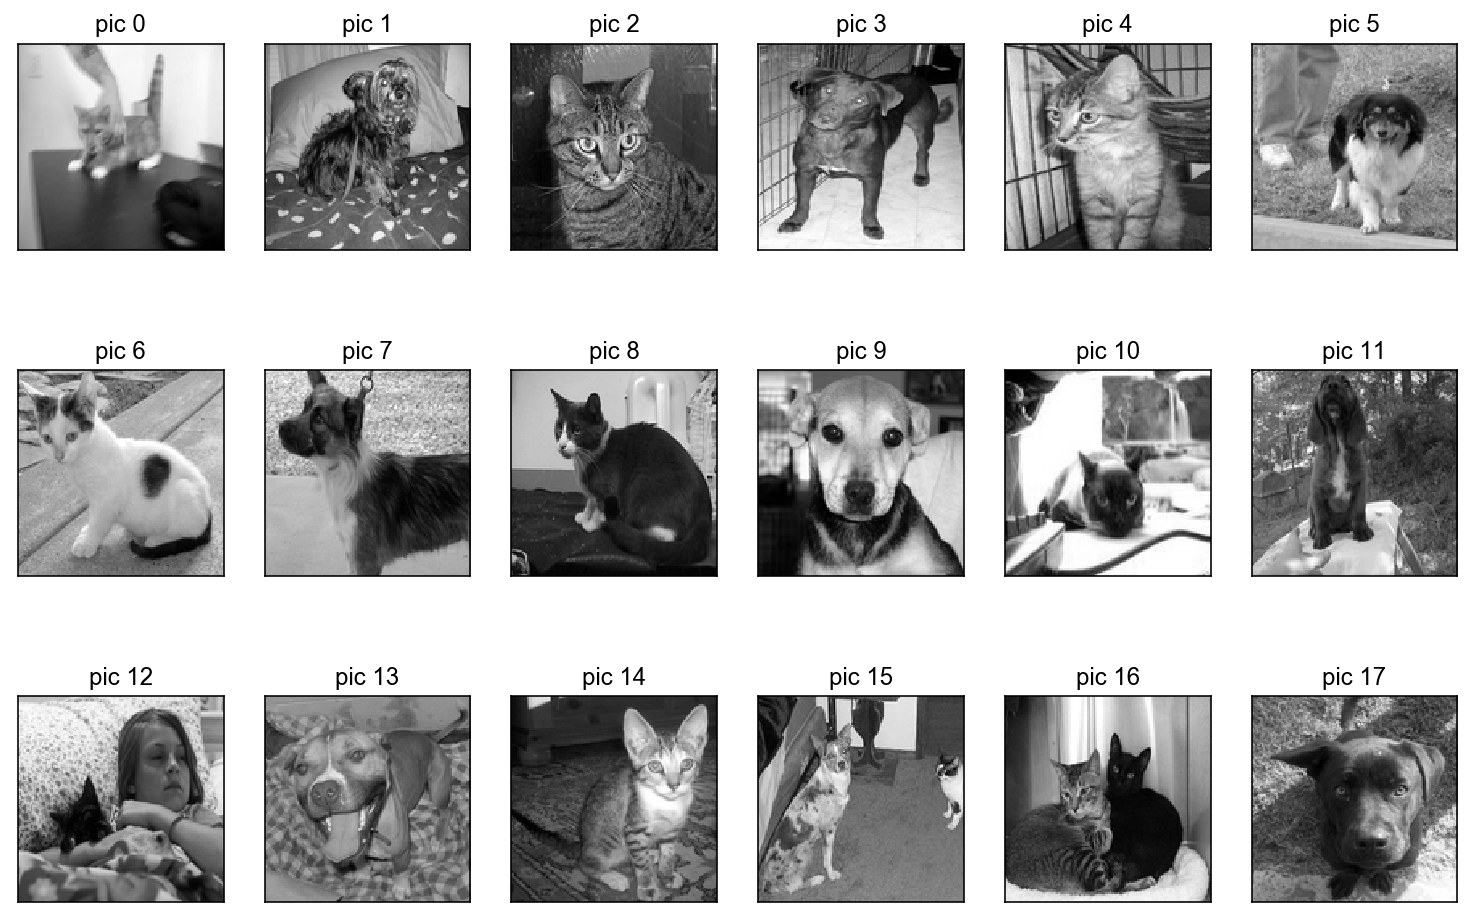

In [8]:
%matplotlib inline
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
img_titles = ["pic %d" % i for i in range(X.shape[0])]
plot_gallery(X, img_titles, 128, 128)

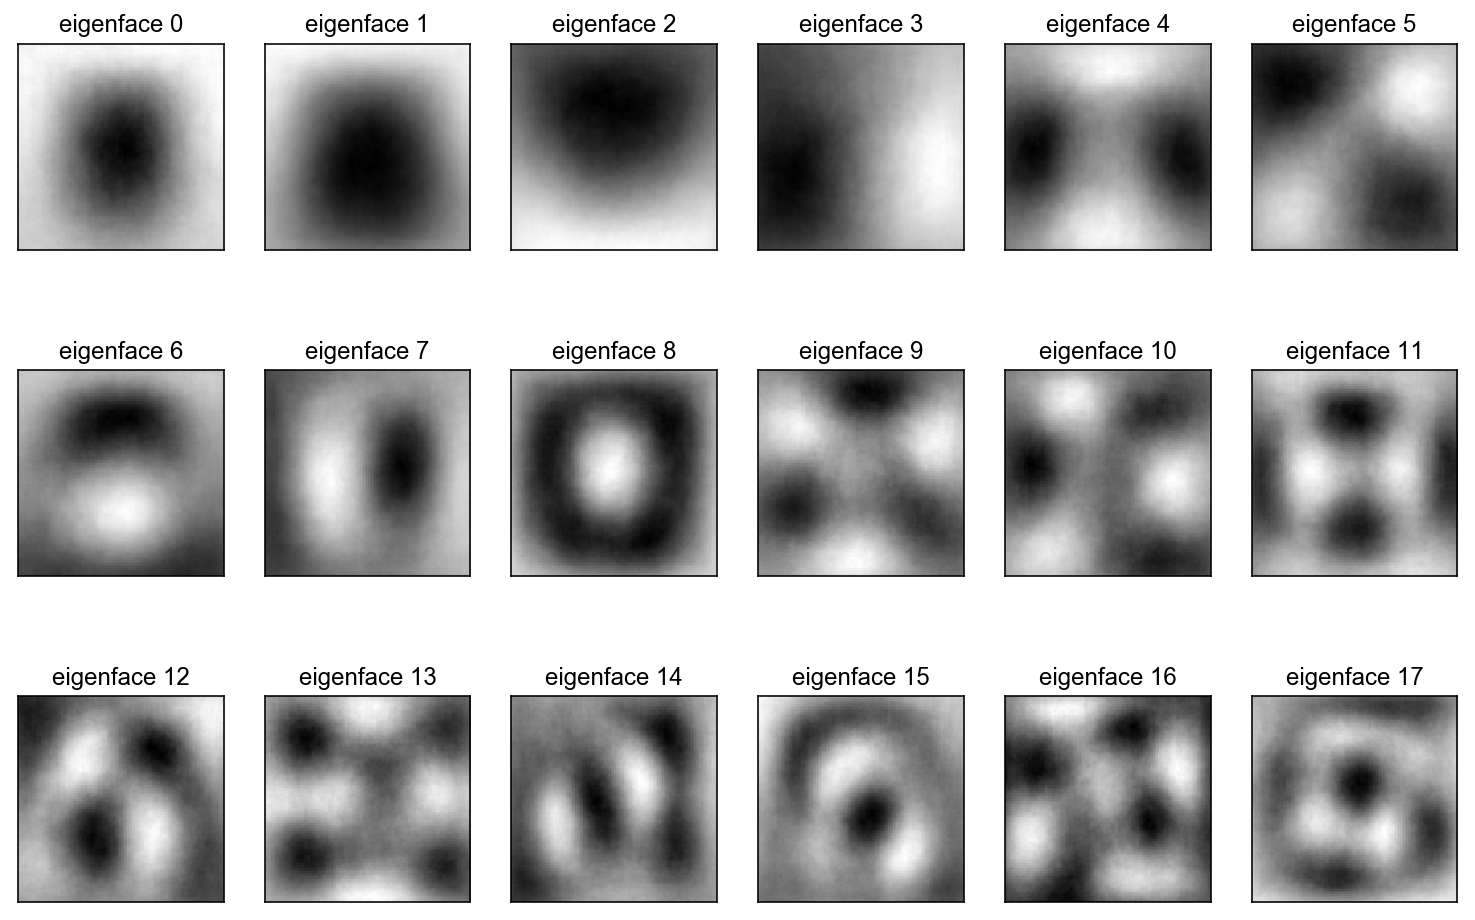

In [9]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 128, 128)

In [10]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 15
img = X[idx_to_reconstruct].reshape(1,-1)
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,img)

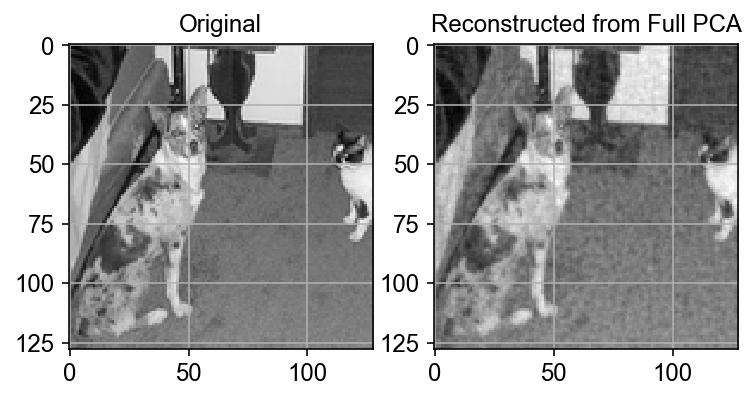

In [11]:
plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape(maxSize), cmap=plt.cm.gray)
plt.title('Original')
plt.grid()
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape(maxSize), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid()

# END CITATION

In [ ]:
from skimage.filters import sobel_h, sobel_v

img = np.asarray(ds.iloc[15]['ImageData']).reshape(maxSize)

gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
plt.imshow(gradient_mag, cmap=plt.cm.gray)
plt.grid()